In [43]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy.random import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn.svm import SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris

# SVM

## Motivation
The math behind the Support Vector Machine (SVM) is relatively complicated. However, the original motivation is quite intuitive. In short, one attempts to utilize a combination of two ideas - finding a linearly separating hyperplane for the data (LDA, K-means) and enlarging the feature space (QDA).

## Support Vector Classifier
Let's begin by specifying the problem. We start with some data $x_i \in R^p$, $y_i \in \{-1, 1\}$. That is, binary classification in $p$ dimensions. We define a hyperplane as $$\{x : f(x) = x^T \beta + \beta_0\ = 0\}$$ and the corresponding classifier $$G(x) = sign(f(x)) = sign(x^T \beta +\beta_0)$$ So put simply, if points are "below" a hyperplane, we classify them as $-1$, and $1$ when they're "above". Now, assuming there exists a plane which separates **all** points, there must be a set of $\beta$ s.t. $y_i f(x_i) > 0, \forall i$. That allows us to further optimize demanding the **margin** (distance) of separation is maximized. This is done by writing it as $$\max M, ||\beta|| = 1$$, while $$y_i(x^T_i \beta + \beta_0) \geq M, \forall i$$

Now, in general, when that is impossible, the clever trick is to still "attempt" to maximize the margin, but allow some "slack" for it, that is $$y_i(x^T_i \beta + \beta_0) \geq M (1 - \xi_i), \xi_i \geq 0$$, $$ \sum_i \xi_i \leq const$$. Since we allow $\xi_i > 1$, some points might be "missclassified" by our hyperplane, but not too many and not by much (exactly how many and how much is controlled by $const$).

After some complicated math in ESL, one can transform this problem into a constrained dual Lagrangian form:
$$ L_D = \sum_i \alpha_i -1/2 \sum_i \sum_{i'} \alpha_i \alpha_{i'} y_i y_{i'} (x^T_i  x_{i'}) $$, where the dot product between $x_i$ and $x_i'$ is emphasized. Finally, one can show that $$\hat{f}(x) = x^T \hat{\beta} + \beta_0 = \sum_i \alpha_i y_i (x^T x_i) + \beta_0$$. Notice that due to certain inequality constraints, only a handful of points (*support vectors*) will contribute to this sum - points which are either missclassified or "weakly" classified, i.e. within a margin $$ y_i (x_i^T \beta + \beta_0) \leq 1$$

Now the critical observation is that in both formulas above **only** the dot products appear. It means that if one enlarges the feature space into a $q$-dimensional one, $q > p$, $h(x) \in R^q$, upon repeating the same calculation, the only thing to pop out would be the evaluations of the Kernel:
$$K(x, x') = \langle h(x), h(x')\rangle$$
Thus, we achieve two goals simultaneously - we enlarge the feature space but restrict the dependence of the classifier on the features $h_j(x), j =1,..q$, thus achieving some regularization.

In [2]:
class_1 = pd.DataFrame(np.random.multivariate_normal([-3, -3], [[1, 0], [0, 1]], 100))
class_2 = pd.DataFrame(np.random.multivariate_normal([3, 3], [[1, 0], [0, 1]], 100))


class_1['label'] = -1
class_2['label'] = 1

lin_data = pd.concat([class_1, class_2], ignore_index=True)


lin_data['label'] = lin_data['label'].astype('category')


print(lin_data.head())

          0         1 label
0 -1.930086 -4.906342    -1
1 -3.511414 -1.949878    -1
2 -3.362311 -2.496245    -1
3 -4.339598 -3.377186    -1
4 -4.926359 -3.766729    -1


In [4]:
X = lin_data.iloc[:, :-1]
y = lin_data['label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

svm_lin = svm.SVC(kernel='linear', C=1.0)


svm_lin.fit(X, y)

print(svm_lin)

SVC(kernel='linear')


In [8]:
def plot_svm_util(svm_fit, data):

    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['label'])

    support_vectors = svm_fit.support_vectors_
    print(support_vectors[:5])  # Print the first 5 support vectors
    print(f"{len(support_vectors)} support vectors")


    cf = svm_fit.coef_[0]
    intercept = svm_fit.intercept_
    print(f"coefs: {cf}")

    # Plot decision boundary
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1])

    yy = (-cf[0] * xx - intercept) / cf[1]
    yy_margin_up = (-cf[0] * xx - intercept + 1) / cf[1]
    yy_margin_down = (-cf[0] * xx - intercept - 1) / cf[1]

    ax.plot(xx, yy, color='red')
    ax.plot(xx, yy_margin_up, color='blue', linestyle='--')
    ax.plot(xx, yy_margin_down, color='blue', linestyle='--')

    plt.show()

[[-1.07967092 -1.38306983]
 [ 1.79177488  0.56127337]]
2 support vectors
coefs: [0.47755267 0.32336542]


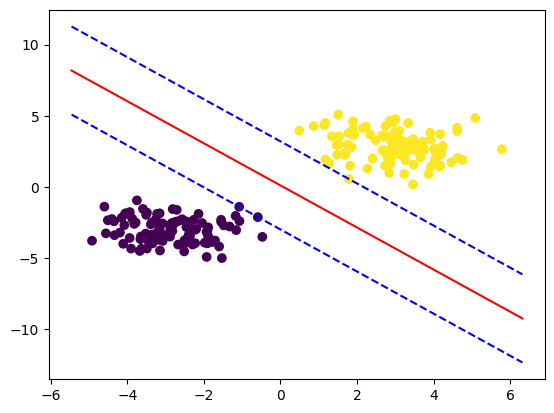

In [9]:
plot_svm_util(svm_lin, lin_data)

## Non-separable data
Let's spoil separability

In [10]:
# Generate multivariate normal data
class_1 = pd.DataFrame(np.random.multivariate_normal([-1, -1], [[1, 0], [0, 1]], 100))
class_2 = pd.DataFrame(np.random.multivariate_normal([1, 1], [[1, 0], [0, 1]], 100))

# Add 'label' column to the dataframes
class_1['label'] = -1
class_2['label'] = 1

lin_data = pd.concat([class_1, class_2], ignore_index=True)

lin_data['label'] = lin_data['label'].astype('category')

lin_data.head()

,0,1,label
0,-0.480016,-2.117715,-1
1,-1.636386,-0.368847,-1
2,0.220599,0.081008,-1
3,-0.237474,1.341785,-1
4,-1.390063,-1.298760,-1


In [12]:
X = lin_data.iloc[:, :-1]
y = lin_data['label']
y = y.astype('int')

svm_list = []

svm_lin = svm.SVC(kernel='linear', C=1.0)

svm_lin.fit(X, y)

svm_list.append(svm_lin)

[[ 0.22059897  0.08100776]
 [-0.23747397  1.34178484]
 [ 0.06572658  0.12150784]
 [-1.25267758  0.21273911]
 [-0.57407835  0.77267216]]
41 support vectors
coefs: [1.14721803 1.40973018]


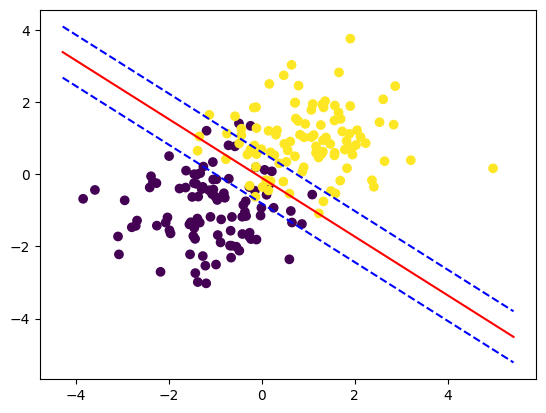

In [13]:
plot_svm_util(svm_lin, lin_data)

Now we have a whole bunch of support vectors (labeled by crosses)

In [14]:
X = lin_data.iloc[:, :-1]
y = lin_data['label']

y = y.astype('int')

svm_lin_new = svm.SVC(kernel='linear', C=0.01)

svm_lin_new.fit(X, y)
print(svm_lin_new)


svm_list.append(svm_lin_new)

SVC(C=0.01, kernel='linear')


[[ 0.22059897  0.08100776]
 [-0.23747397  1.34178484]
 [ 0.06572658  0.12150784]
 [-1.25267758  0.21273911]
 [-0.57407835  0.77267216]]
41 support vectors
coefs: [1.14721803 1.40973018]


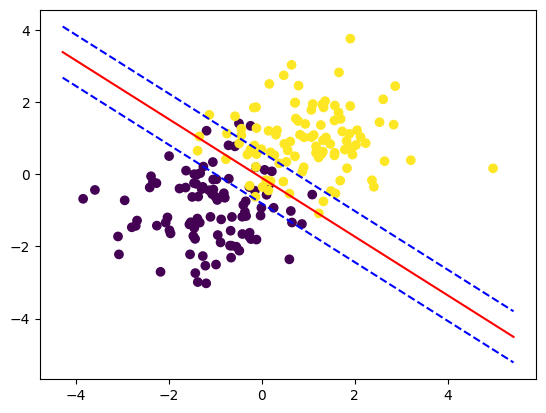

In [15]:
plot_svm_util(svm_lin, lin_data)

In [20]:
def plot_svm(model, X, y):
    # plot the line, the points, and the nearest vectors to the plane
    plt.figure()
    plt.clf()

    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, zorder=10, cmap=plt.cm.bwr)

    plt.axis('tight')
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = model.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])

    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
                facecolors='none', zorder=10, edgecolors='k')

    plt.show()

def plot_filled_svm(model, X, y):
    # create a mesh to plot in
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    h = (x_max - x_min)/100  # adjusted the calculation of h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    plt.figure()
    plt.subplot(1, 1, 1)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title('SVM Classification Plot')

    # Adding the color bar
    plt.colorbar()

    plt.show()

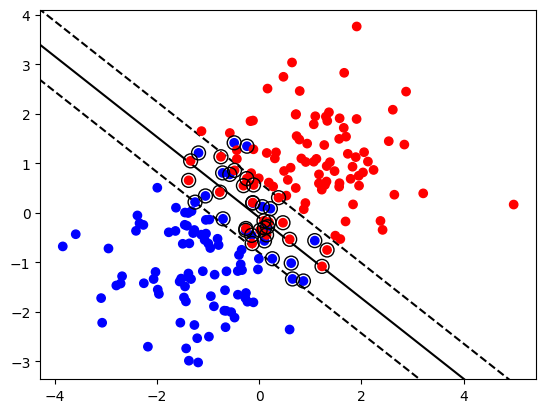

In [17]:
X = lin_data.iloc[:, :-1]
y = lin_data['label']
plot_svm(svm_lin, X, y)

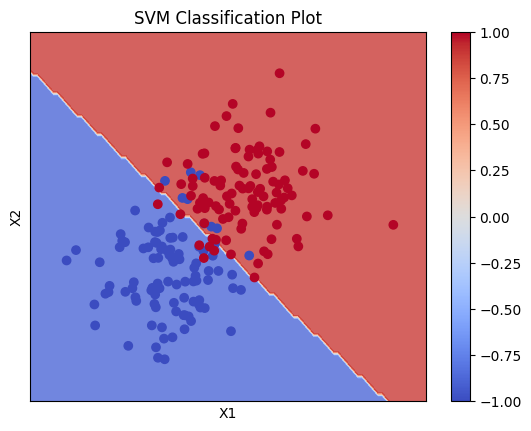

In [21]:
X = lin_data.iloc[:, :-1]
y = lin_data['label']

plot_filled_svm(svm_lin, X, y)

Notice the margin widens with decreased cost constant and vice-versa.

## Separable in quadratic variables

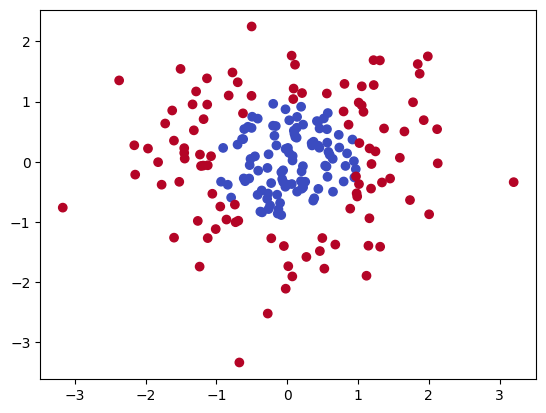

In [23]:
class_1 = []
class_2 = []

# Generate data for class_1 and class_2
while len(class_1) < 100:
    tmp_x = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    if np.sum(tmp_x**2) < 1:
        class_1.append(tmp_x)

while len(class_2) < 100:
    tmp_x = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    if np.sum(tmp_x**2) > 1:
        class_2.append(tmp_x)

# Convert lists to numpy arrays
class_1 = np.array(class_1)
class_2 = np.array(class_2)

# Assign labels
labels_1 = np.full(class_1.shape[0], -1)
labels_2 = np.full(class_2.shape[0], 1)

# Combine the datasets
nlin_data = np.vstack((class_1, class_2))
labels = np.concatenate((labels_1, labels_2))

# Plot the data points
plt.scatter(nlin_data[:, 0], nlin_data[:, 1], c=labels, cmap=plt.cm.coolwarm)
plt.show()

In [27]:
nlin_data_df = pd.DataFrame(nlin_data, columns=['X1', 'X2'])
labels_series = pd.Series(labels)

svm_nlin = SVC(kernel='poly', degree=2, C=1)
svm_nlin.fit(nlin_data_df, labels_series)

predicted_labels = svm_nlin.predict(nlin_data_df)

print(confusion_matrix(labels_series, predicted_labels))

# Print the SVM model
print(svm_nlin)

[[100   0]
 [  4  96]]
SVC(C=1, degree=2, kernel='poly')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


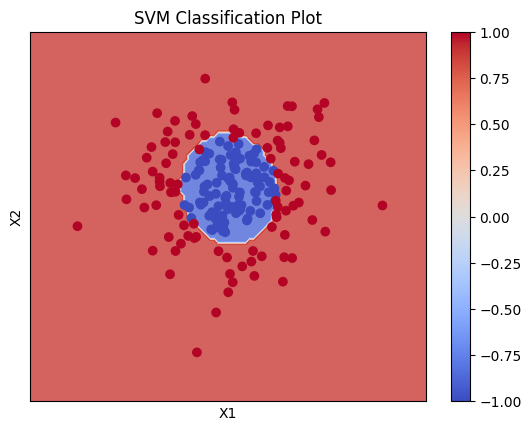

In [29]:
plot_filled_svm(svm_nlin, nlin_data_df, labels_series)

In [30]:
svm_nlin = SVC(kernel='poly', degree=10, C=1)
svm_nlin.fit(nlin_data, labels)

predicted_labels = svm_nlin.predict(nlin_data)

print(confusion_matrix(labels, predicted_labels))

[[100   0]
 [ 17  83]]


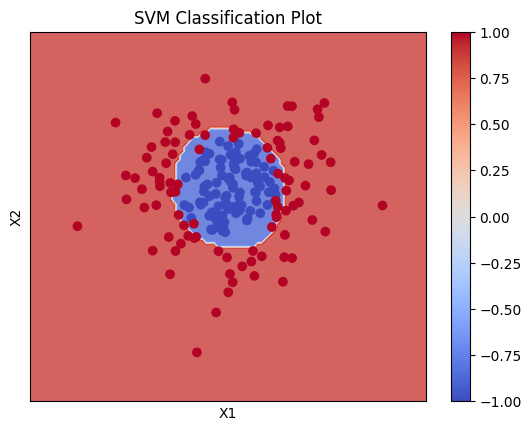

In [31]:
plot_filled_svm(svm_nlin, nlin_data_df, labels_series)

Separable in the space of the quadratic features induced by the kernel!

## More realistic data

In [33]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train an SVM model with default settings (RBF Kernel)
model = SVC()
model.fit(X_train, y_train)

# Print the model details
print(model)

# Print the summary of the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=iris.target_names))

SVC()
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [34]:
y_train_pred = model.predict(X_train)

# Print the confusion matrix
print(confusion_matrix(y_train, y_train_pred))

[[31  0  0]
 [ 0 34  3]
 [ 0  1 36]]


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


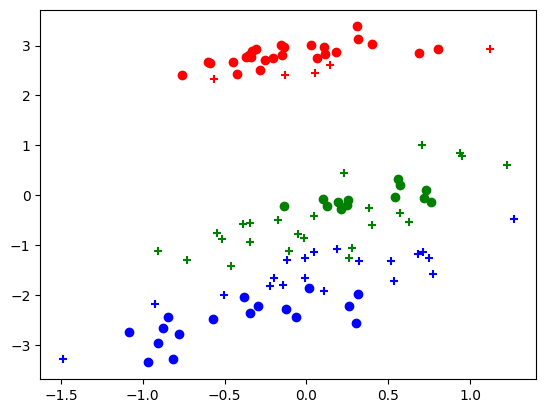

In [37]:
dists = pairwise_distances(X_train)
mds = MDS(dissimilarity='precomputed')
coords = mds.fit_transform(dists)

# Get the indices of support vectors
support_vector_indices = model.support_

# Assign colors and markers based on the classes and support vectors
colors = ['red', 'green', 'blue']
markers = np.where(np.isin(range(len(X_train)), support_vector_indices), '+', 'o')

# Plot the transformed data
for i, (x, y) in enumerate(coords):
    plt.scatter(x, y, color=colors[y_train[i]], marker=markers[i])

plt.show()

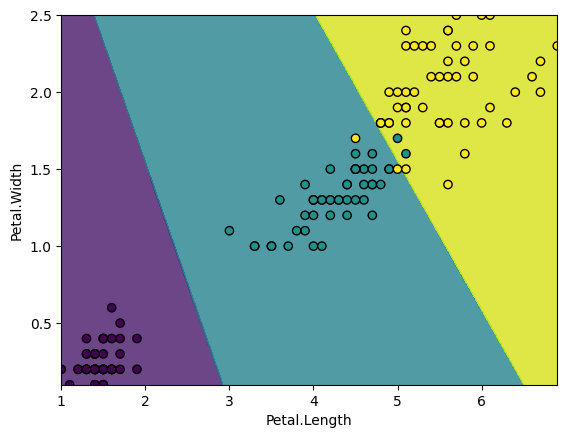

In [38]:
iris = datasets.load_iris()
X = iris.data[:, 2:]  # Only take Petal.Length and Petal.Width for simplicity
y = iris.target

# Train the SVM
clf = SVC(kernel='linear')
clf.fit(X, y)

# Plot the decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 500),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 500))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.xlabel('Petal.Length')
plt.ylabel('Petal.Width')
plt.show()

K > 2 is typically handled by K*(K-1)/2 instances of one-vs-many classifiers

In [40]:
model = SVC()
model.fit(X_train, y_train)

# Predict the labels for the test data
y_test_pred = model.predict(X_test)

# Print the confusion matrix
print(confusion_matrix(y_test, y_test_pred))

[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


## Support vector regression
Can also be used for regression, under a suitable choice of a Loss function.
$$ L_{\epsilon}= 0, |x| < \epsilon,
L_{\epsilon} = |x| - \epsilon, |x| \geq \epsilon$$

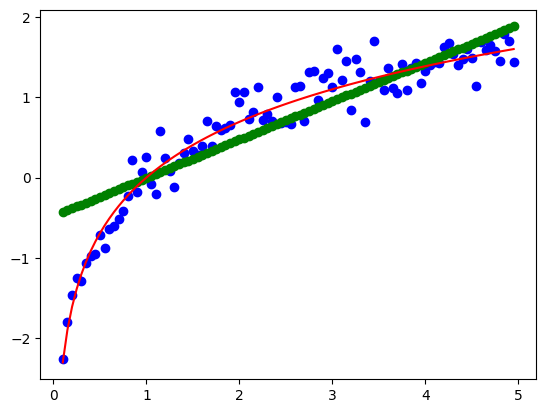

In [42]:
x = np.arange(0.1, 5, 0.05)
y = np.log(x) + np.random.normal(0, 0.2, len(x))

# Reshape x to a 2D array with one column
X = x.reshape(-1, 1)

# Fit the model and make predictions
model = SVR(kernel='linear')
model.fit(X, y)
predictions = model.predict(X)

# Visualize the results
plt.scatter(x, y, color='blue')  # plot the generated data
plt.plot(x, np.log(x), color='red')  # plot the true log(x)
plt.scatter(x, predictions, color='green')  # plot the predictions
plt.show()

# Flexible discriminant analysis

In short, this a sophisticated trick to simultaneously enlarge the possible feature space from LDA to more general non-linear features, while fitting the discriminant function from a rich model set such as smooth splines or MARS.

In [44]:
iris = load_iris()
X = iris.data
y = iris.target

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

y_pred = lda.predict(X)

confusion_mtx = confusion_matrix(y, y_pred)
print(confusion_mtx)

[[50  0  0]
 [ 0 48  2]
 [ 0  1 49]]


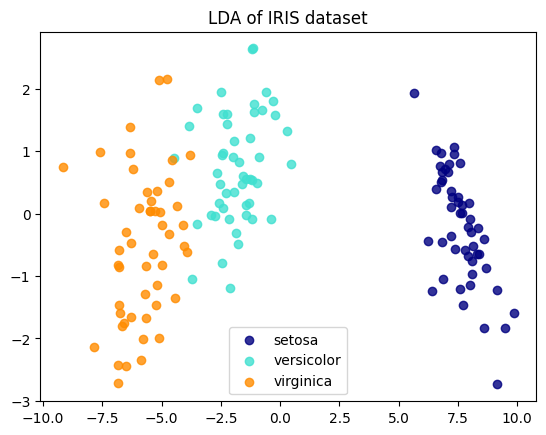

In [45]:
iris = load_iris()
X = iris.data
y = iris.target

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')
plt.show()

In [46]:
!pip install pyearth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.1 MB/s eta 0:00:00
